<a href="https://colab.research.google.com/github/td-yoshimura/hivemall-notebooks/blob/master/notebooks/churn/decision_tree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 概要

[Churnデータセット](https://aws.amazon.com/blogs/machine-learning/predicting-customer-churn-with-amazon-machine-learning/) をTreasure Data環境にアップロードして、解約者の予測を行います。  
モデルにはDecision Treeを使います。  
事前に必要なものは、
- Treasure Dataのユーザ名とパスワード
- Treasure DataのAPIキー
- Databaseの作成  
のみです。


In [0]:
%env TD_API_KEY = YOUR API
%env DATABASE = YOUR DATABASE NAME

#  セットアップ

<font color="red"><b>以下のセルを実行するとTreasure Dataのユーザ名とパスワードの入力を求められるので入力してください。</b></font>

In [0]:
!curl -L https://toolbelt.treasuredata.com/sh/install-ubuntu-trusty-td-agent2.sh | sh
!td account -f
!pip install pandas-td

In [0]:
import os
td_api_key = os.environ['TD_API_KEY']
database = os.environ['DATABASE']
table = 'churn_dataset'

import numpy as np
import pandas as pd
from sklearn.datasets import fetch_20newsgroups
import seaborn as sns

import pandas_td as td
con = td.connect(apikey=td_api_key)

%matplotlib inline
%load_ext pandas_td.ipython
%td_use $database

import pandas as pd
import matplotlib.pyplot as plt
pd.options.display.max_columns = 30

presto = td.create_engine('presto:{}'.format(database), con=con)
hive = td.create_engine('hive:{}'.format(database), con=con)

# データの準備

以下のセルを実行すると利用しているTreasure Data環境にテーブルが作成されます。  
５分程度時間がかかります。

In [0]:
!wget http://dataminingconsultant.com/DKD2e_data_sets.zip
!unzip -o DKD2e_data_sets.zip
!chmod 777 Data\ sets/churn.txt
!td table:delete -f ${DATABASE} churn_dataset; td table:create ${DATABASE} churn_dataset
!td import:auto \
  --format csv \
  --columns state,account_length,area_code,phone,intl_plan,vmail_plan,vmail_message,day_mins,day_calls,day_charge,eve_mins,eve_calls,eve_charge,night_mins,night_calls,night_charge,intl_mins,intl_calls,intl_charge,cust_serv_calls,is_churn \
  --column-types string,int,string,string,string,string,int,double,int,double,double,int,double,double,int,double,double,int,double,int,string \
  --auto-create ${DATABASE}.churn_dataset \
  --time-value 1545896745 \
  ./Data\ sets/churn.txt

テーブルを確認します。

In [5]:
%%td_presto
select
  is_churn,state,account_length,area_code,phone,intl_plan,vmail_plan,vmail_message,day_mins,day_calls,day_charge,eve_mins,eve_calls,eve_charge,night_mins,night_calls,night_charge,intl_mins,intl_calls,intl_charge,cust_serv_calls
from
  churn_dataset
limit 2

is_churn state  account_length area_code     phone intl_plan vmail_plan  \
0   False.    WI              93       415  392-6286        no         no   
1   False.    OK             149       510  365-9079       yes         no   

   vmail_message  day_mins  day_calls  day_charge  eve_mins  eve_calls  \
0              0     152.1        141       25.86     215.5        107   
1              0     180.9         79       30.75     194.9         83   

   eve_charge  night_mins  night_calls  night_charge  intl_mins  intl_calls  \
0       18.32       262.4          111         11.81       12.0           7   
1       16.57       197.8          109          8.90        8.8           9   

   intl_charge  cust_serv_calls  
0         3.24                1  
1         2.38                3

各カラムの詳細です。  
https://aws.amazon.com/blogs/machine-learning/predicting-customer-churn-with-amazon-machine-learning/

**Columns**
- state: the US state in which the customer resides, indicated by a two-letter abbreviation; for example, OH or NJ
- account_length: the number of days that this account has been active
- area_code: the three-digit area code of the corresponding customer’s phone number
- phone: the remaining seven-digit phone number
- intl_plan: whether the customer has an international calling plan: yes/no
- vmail_plan: whether the customer has a voice mail feature: yes/no
- vmail_message: presumably the average number of voice mail messages per month
- day_mins: the total number of calling minutes used during the day
- day_calls: the total number of calls placed during the day
- day_charge: the billed cost of daytime calls
- eve_mins, eve_calls, eve_charge: the billed cost for calls placed during the evening
- night_mins, night_calls, night_charge: the billed cost for calls placed during nighttime
- intl_mins, intl_calls, intl_charge: the billed cost for international calls
- cust_serv_calls: the number of calls placed to Customer Service
- is_churn: whether the customer left the service: true/false

# EDA (Explore Data Analysis)
機械学習の処理を行う前に、データを正しく把握することが重要です。  
そのために記述統計量の確認や可視化を行います。

## Data Size

In [6]:
%%td_presto
select
  count(*)
from
  churn_dataset

_col0
0   3333

## Check if null value exists

In [7]:
%%td_presto
select
  count(is_churn) as is_churn,
  count(state) as state,
  count(account_length) as account_length,
  count(area_code) as area_code,
  count(phone) as phone,
  count(intl_plan) as intl_plan,
  count(vmail_plan) as vmail_plan,
  count(vmail_message) as vmail_message,
  count(day_mins) as day_mins,
  count(day_calls) as day_calls,
  count(day_charge) as day_charge,
  count(eve_mins) as eve_mins,
  count(eve_calls) as eve_calls,
  count(eve_charge) as eve_charge,
  count(night_mins) as night_mins,
  count(night_calls) as night_calls,
  count(night_charge) as night_charge,
  count(intl_mins) as intl_mins,
  count(intl_calls) as intl_calls,
  count(intl_charge) as intl_charge,
  count(cust_serv_calls) as cust_serv_calls
from
  churn_dataset

is_churn  state  account_length  area_code  phone  intl_plan  vmail_plan  \
0      3333   3333            3333       3333   3333       3333        3333   

   vmail_message  day_mins  day_calls  day_charge  eve_mins  eve_calls  \
0           3333      3333       3333        3333      3333       3333   

   eve_charge  night_mins  night_calls  night_charge  intl_mins  intl_calls  \
0        3333        3333         3333          3333       3333        3333   

   intl_charge  cust_serv_calls  
0         3333             3333

Nullは含まれていませんでした。

## 目的変数

In [8]:
%%td_presto
select
  is_churn
  ,count(*) as n
from
  churn_dataset
group by
  1

is_churn     n
0    True.   483
1   False.  2850

## state(string)

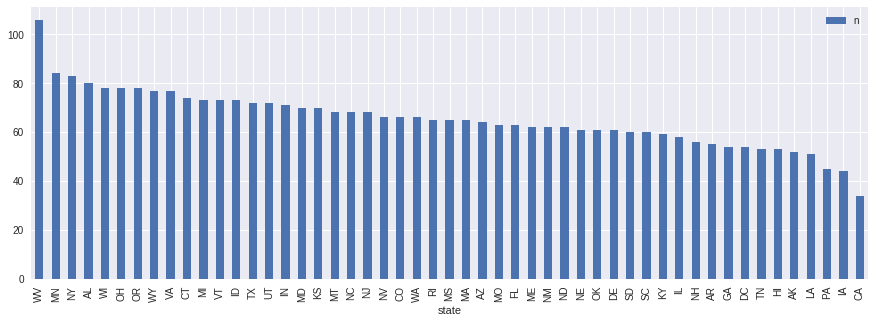

In [9]:
td.read_td_query('''
select
  state
  ,count(*) as n
from
  churn_dataset
group by
  1
order by
  2 desc
''', engine=presto, index_col='state').plot.bar(figsize=(15,5))

## account_length (int)

In [10]:
%%td_presto
select
  avg(account_length) as average
  ,min(account_length) as min
  ,approx_percentile(account_length, 0.25) as pct_25th
  ,approx_percentile(account_length, 0.50) as pct_50th
  ,approx_percentile(account_length, 0.75) as pct_75th
  ,max(account_length) as max
from
  churn_dataset

average  min  pct_25th  pct_50th  pct_75th  max
0  101.064806    1        74       101       127  243

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1a7e99b6d8>]],
      dtype=object)

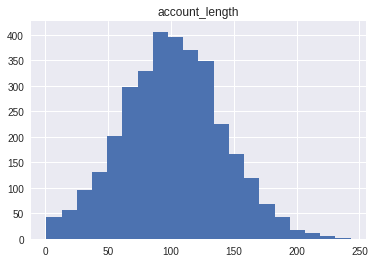

In [11]:
td.read_td_query('''
  select
    account_length
  from
    churn_dataset
''', engine=presto).hist(bins=20)

## area_code (string)

In [12]:
%%td_presto
select
  area_code
  ,count(*) as n
from
  churn_dataset
group by
  1
order by
  2 desc

area_code     n
0       415  1655
1       510   840
2       408   838

## phone(string)
このカラムは各行に一意の値が割り振られているので、機械学習の説明変数としては使うことができません。

In [13]:
%%td_presto
select
  count(phone) as n
  ,count(distinct phone) as n_unique
from
  churn_dataset

n  n_unique
0  3333      3333

## intl_plan(string)

In [14]:
%%td_presto
select
  intl_plan
  ,count(*) as n
from
  churn_dataset
group by
  1
order by
  2 desc

intl_plan     n
0        no  3010
1       yes   323

## vmail_plan(string)

In [15]:
%%td_presto
select
  vmail_plan
  ,count(*) as n
from
  churn_dataset
group by
  1
order by
  2 desc

vmail_plan     n
0         no  2411
1        yes   922

## vmail_message(int)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1a7c897780>]],
      dtype=object)

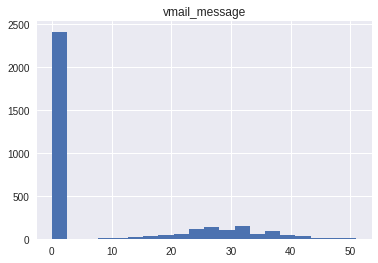

In [16]:
td.read_td_query('''
select
  vmail_message
from
  churn_dataset
''', engine=presto).hist(bins=20)

## day_mins(double)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1a7e9e4908>]],
      dtype=object)

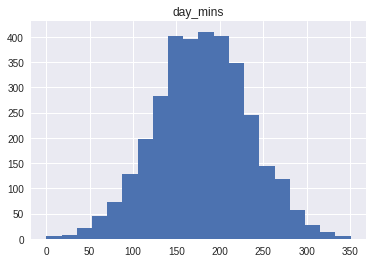

In [17]:
td.read_td_query('''
select
  day_mins
from
  churn_dataset
''', engine=presto).hist(bins=20)

## day_calls(int)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1a7c783ac8>]],
      dtype=object)

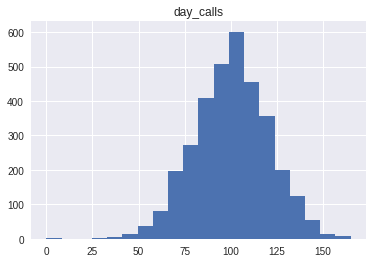

In [18]:
td.read_td_query('''
select
  day_calls
from
  churn_dataset
''', engine=presto).hist(bins=20)

## day_charge(double)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1a7c7009b0>]],
      dtype=object)

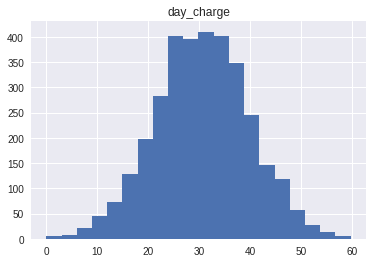

In [19]:
td.read_td_query('''
select
  day_charge
from
  churn_dataset
''', engine=presto).hist(bins=20)

## eve_mins(double)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1a7c6abc50>]],
      dtype=object)

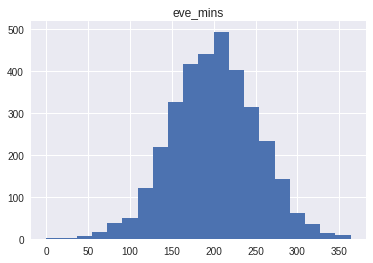

In [20]:
td.read_td_query('''
select
  eve_mins
from
  churn_dataset
''', engine=presto).hist(bins=20)

## eve_calls(int)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1a7c5f88d0>]],
      dtype=object)

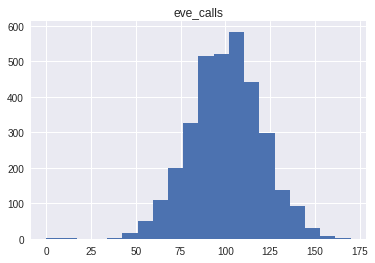

In [21]:
td.read_td_query('''
select
  eve_calls
from
  churn_dataset
''', engine=presto).hist(bins=20)

## eve_charge(double)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1a7c88a828>]],
      dtype=object)

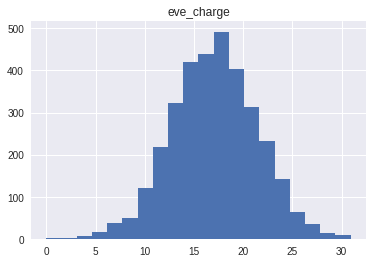

In [22]:
td.read_td_query('''
select
  eve_charge
from
  churn_dataset
''', engine=presto).hist(bins=20)

## night_mins(double)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1a7c4b9860>]],
      dtype=object)

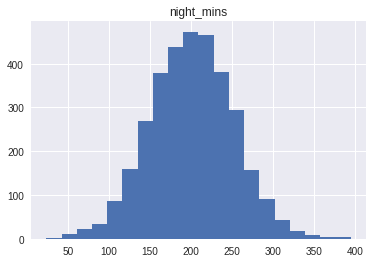

In [23]:
td.read_td_query('''
select
  night_mins
from
  churn_dataset
''', engine=presto).hist(bins=20)

## night_calls(int)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1a7c43e0b8>]],
      dtype=object)

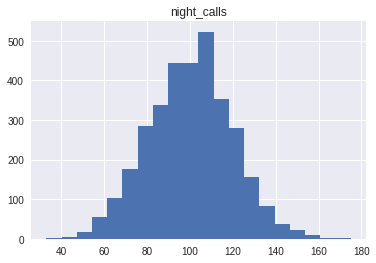

In [24]:
td.read_td_query('''
select
  night_calls
from
  churn_dataset
''', engine=presto).hist(bins=20)

## night_charge(double)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1a7c4239e8>]],
      dtype=object)

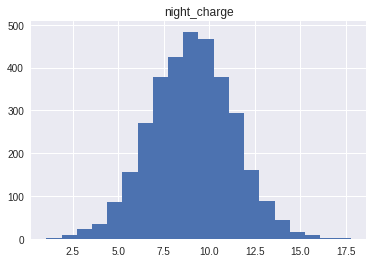

In [25]:
td.read_td_query('''
select
  night_charge
from
  churn_dataset
''', engine=presto).hist(bins=20)

## intl_mins(double)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1a7c330c88>]],
      dtype=object)

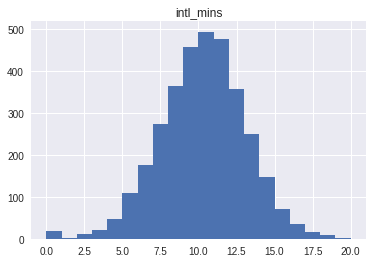

In [26]:
td.read_td_query('''
select
  intl_mins
from
  churn_dataset
''', engine=presto).hist(bins=20)

## intl_calls(int)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1a7c2fd3c8>]],
      dtype=object)

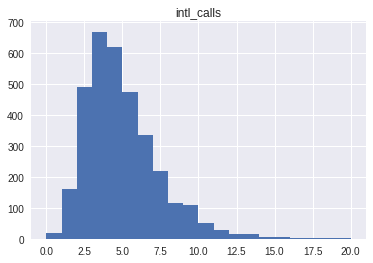

In [27]:
td.read_td_query('''
select
  intl_calls
from
  churn_dataset
''', engine=presto).hist(bins=20)

## intl_charge (double)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1a7c246198>]],
      dtype=object)

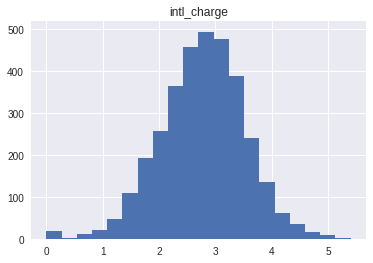

In [28]:
td.read_td_query('''
select
  intl_charge
from
  churn_dataset
''', engine=presto).hist(bins=20)

## cust_serv_calls

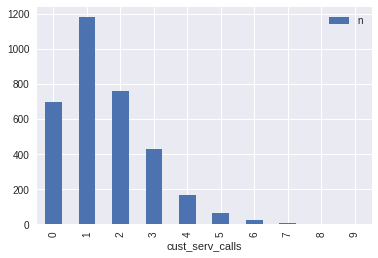

In [29]:
td.read_td_query('''
select
  cust_serv_calls
  ,count(*) as n
from
  churn_dataset
group by
  1
''', engine=presto, index_col='cust_serv_calls').sort_index().plot.bar()

## Correlations / 相関
With python library, you can visuazlie the relashionship between variables.
<br>
Pythonを利用して、変数間の相関を可視化します。

In [0]:
df = td.read_td_query('''
  select
    case when is_churn like 'True.' then 1 else 0 end as is_churn
    ,state,account_length,area_code,intl_plan,vmail_plan,vmail_message,day_mins,day_calls,day_charge,eve_mins,eve_calls,eve_charge,night_mins,night_calls,night_charge,intl_mins,intl_calls,intl_charge,cust_serv_calls
  from
    churn_dataset    
''', engine=presto)

### Scatter plot / 散布図

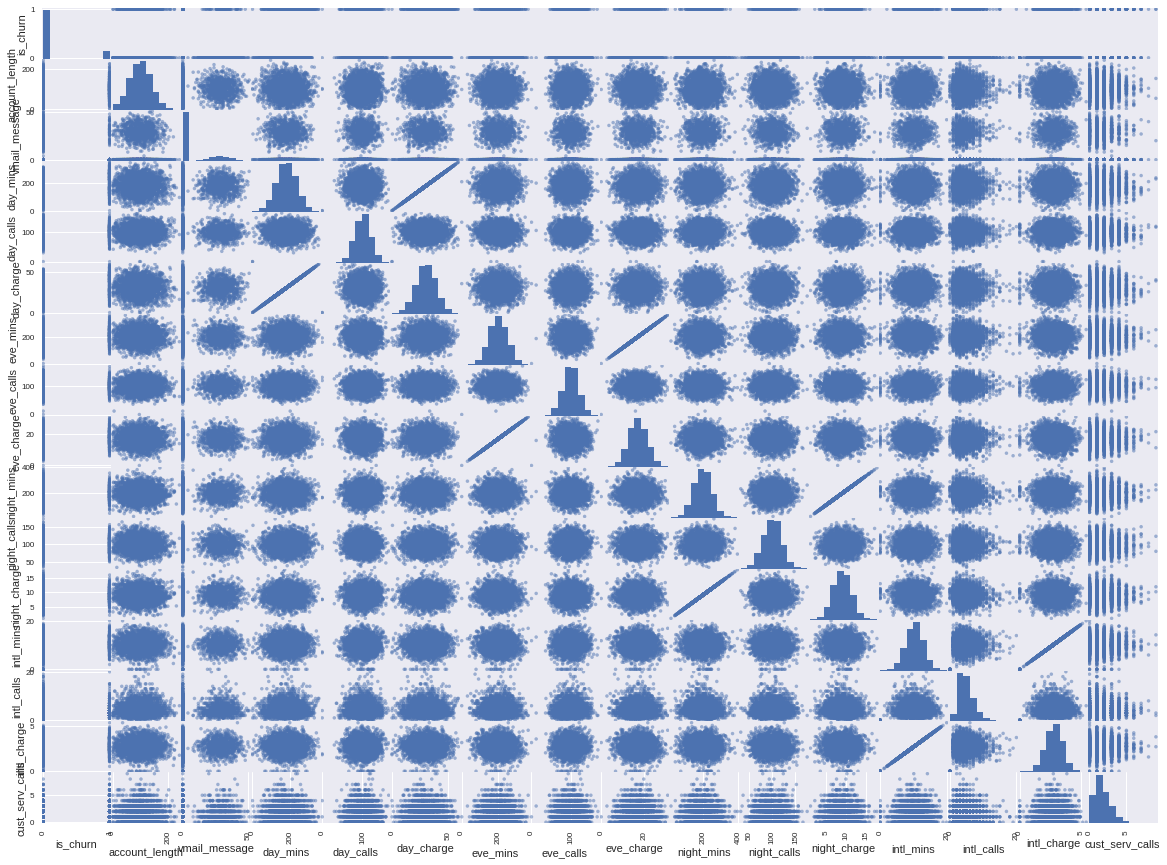

In [31]:
pd.plotting.scatter_matrix(df, figsize=(20,15))
plt.show()

### Correlatiion coefficient matrix / 相関行列

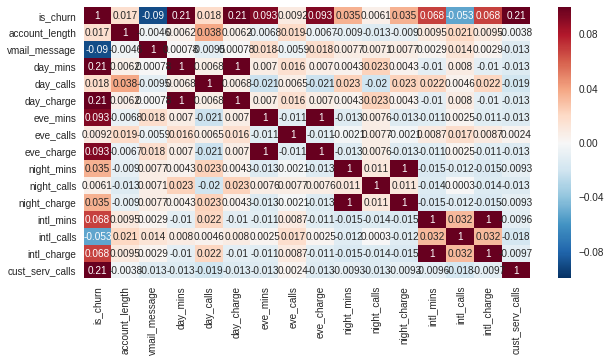

In [32]:
fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(df.corr(), annot=True, ax=ax, vmin=-0.1, vmax=0.1)
plt.show()

(day_mins, day_charge) , (eve_mins, eve_charge), (intl_mins, intl_charge) の３つのペアは相関係数が `1.0` となっています。  
[多重共線性](https://en.wikipedia.org/wiki/Multicollinearity) のため、各ペアのいずれかの変数は説明変数から除外します。

# 機械学習

### Preprocess / 前処理

- Data is splitted into training data and test data. 
- String columns are expanded to binary columns.
- Remove unnecessary columns in consideration of [EDA](https://colab.research.google.com/drive/1k062r8-jXhlnU_vjbHCI-Z_yGxt96iE2#scrollTo=CEqJzaJ-rC78)

<br>

- データを学習データと検証データに分けます
- 文字列のカラムはバイナリのカラムに展開します。
- 不要なカラムは除きます。

In [33]:
!td table:delete -f $DATABASE churn_preprocessed; td table:create $DATABASE churn_preprocessed

Table 'hivemall.churn_preprocessed' is deleted.
Table 'hivemall.churn_preprocessed' is created.


In [35]:
%%td_hive
with add_num as (
  select
    row_number() over() as rownum
    ,*
  from
    churn_dataset
)

,target as (
  select
    rownum
    ,case when is_churn like 'False.' then 0 else 1 end as target
    ,case when rand() < 0.8 then 'train' else 'test' end as class
  from
    add_num
)

,features as (
  select
    quantify(true,
             rownum,state,area_code,intl_plan,vmail_plan,account_length,vmail_message,day_calls,eve_calls,night_calls,intl_calls,cust_serv_calls,day_mins,eve_mins,night_mins,intl_mins
             ) as (rownum,state,area_code,intl_plan,vmail_plan,account_length,vmail_message,day_calls,eve_calls,night_calls,intl_calls,cust_serv_calls,day_mins,eve_mins,night_mins,intl_mins)
  from
    add_num
)

insert overwrite table churn_preprocessed
select
  target.rownum
  ,target.class
  ,target.target
  ,array(state,area_code,intl_plan,vmail_plan,account_length,vmail_message,day_calls,eve_calls,night_calls,intl_calls,cust_serv_calls,day_mins,eve_mins,night_mins,intl_mins) as features
  ,state,area_code,intl_plan,vmail_plan,account_length,vmail_message,day_calls,eve_calls,night_calls,intl_calls,cust_serv_calls,day_mins,eve_mins,night_mins,intl_mins
from
  target
  left outer join
  features
  on
    target.rownum = features.rownum

Empty DataFrame
Columns: [rownum, class, target, features, state, area_code, intl_plan, vmail_plan, account_length, vmail_message, day_calls, eve_calls, night_calls, intl_calls, cust_serv_calls, day_mins, eve_mins, night_mins, intl_mins]
Index: []

作成したテーブルを確認します。

In [36]:
%%td_presto
select
  *
from
  churn_preprocessed
limit 2

rownum  class  target  \
time                                         
2019-01-18 04:25:25       1  train       0   
2019-01-18 04:25:25       2  train       0   

                                                              features  state  \
time                                                                            
2019-01-18 04:25:25  [0.0, 0.0, 0.0, 0.0, 164.0, 0.0, 111.0, 126.0,...      0   
2019-01-18 04:25:25  [1.0, 1.0, 0.0, 0.0, 93.0, 0.0, 71.0, 108.0, 1...      1   

                     area_code  intl_plan  vmail_plan  account_length  \
time                                                                    
2019-01-18 04:25:25          0          0           0             164   
2019-01-18 04:25:25          1          0           0              93   

                     vmail_message  day_calls  eve_calls  night_calls  \
time                                                                    
2019-01-18 04:25:25              0        111        126          112   
2019-01-18 04:25:25              0         71        108          121   

                     intl_calls  cust_serv_calls  day_mins  eve_mins  \
time                                                                   
2019-01-18 04:25:25           3                1     160.6     163.2   
2019-01-18 04:25:25           3                2     271.6     229.4   

                     night_mins  intl_mins  
time                                        
2019-01-18 04:25:25       187.1        9.0  
2019-01-18 04:25:25        77.3       10.9

### 決定木モデルの構築

In [37]:
!td table:delete -f $DATABASE churn_dt_model; td table:create $DATABASE churn_dt_model

Table 'hivemall.churn_dt_model' is deleted.
Table 'hivemall.churn_dt_model' is created.


In [111]:
%%td_hive
insert overwrite table churn_dt_model
select
  train_randomforest_classifier(
    features,
    target,
    '-attrs C,C,C,C,Q,Q,Q,Q,Q,Q,Q,Q,Q,Q,Q -trees 1 -depth 4 -vars 15'
  )
from
  churn_preprocessed
where
  class like 'train'

Empty DataFrame
Columns: [model_id, model_weight, model, var_importance, oob_errors, oob_tests]
Index: []

テーブルを確認します。

In [112]:
%%td_presto
select
  model_id, model_weight, model
from
  churn_dt_model

model_id  model_weight  \
0  4f465e98-fea3-462f-978f-2ab147af226a       0.88755   

                                               model  
0  I?z:MQ}ek*KCWQFBrIg-zvk-YJJtWxIoy*yCWR$A(nS*c|...

#### 決定木のビジュアライズ

`churn_dt_model` の `model` カラムがモデルの詳細な情報が含まれています。  
これをビジュアライズします。

In [0]:
f = open('tree.dot', 'w')
tree = td.read_td_query('''select
  model_id,
  tree_export(model, "-type graphviz", array('state','area_code','intl_plan','vmail_plan','account_length','vmail_message','day_calls','eve_calls','night_calls','intl_calls','cust_serv_calls','day_mins','eve_mins','night_mins','intl_mins'), array('0','1')) as dot
from
  churn_dt_model
''', engine=hive)['dot'][0]
f.write(tree)
f.close()

In [0]:
!dot -Tpng tree.dot -o tree.png

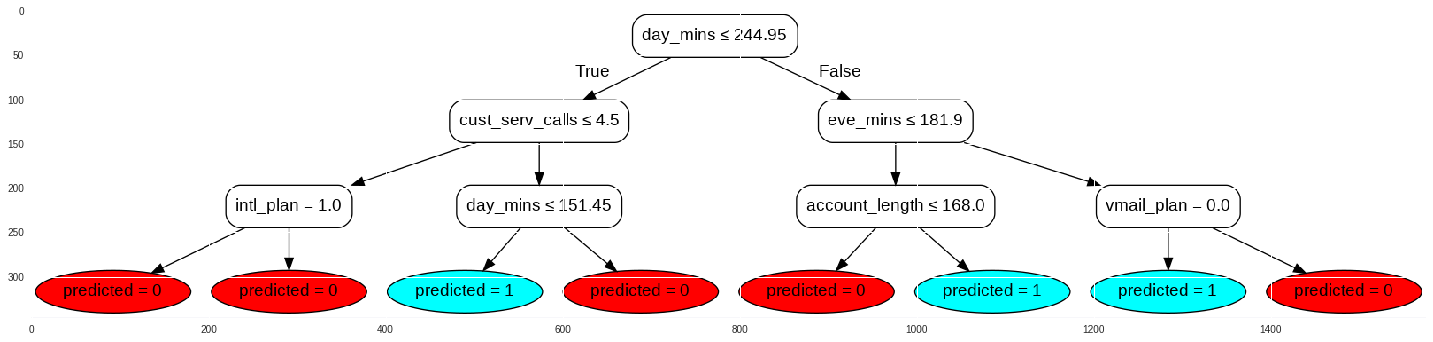

In [133]:

from PIL import Image
im = Image.open("tree.png", "r")
fig, ax = plt.subplots(figsize=(25,50))
ax.imshow(np.array(im));plt.show()

#### 変数の重要度

In [123]:
%%td_hive
select
  num
  ,subarray(array('state','area_code','intl_plan','vmail_plan','account_length','vmail_message','day_calls','eve_calls','night_calls','intl_calls','cust_serv_calls','day_mins','eve_mins','night_mins','intl_mins'), num - 1, num)[0] as feature
  ,subarray(var_importance, num - 1, num)[0] as importance
from
  churn_dt_model
lateral view
  generate_series(1,15) t as num
order by
  importance desc

num          feature  importance
0    12         day_mins    0.220281
1     4       vmail_plan    0.122284
2    13         eve_mins    0.105007
3     5   account_length    0.064026
4    11  cust_serv_calls    0.017442
5     3        intl_plan    0.012367
6    15        intl_mins    0.000000
7    14       night_mins    0.000000
8    10       intl_calls    0.000000
9     9      night_calls    0.000000
10    8        eve_calls    0.000000
11    7        day_calls    0.000000
12    6    vmail_message    0.000000
13    2        area_code    0.000000
14    1            state    0.000000

### Prediction  / 予測

In [125]:
!td table:delete -f $DATABASE churn_dt_pred;td table:create $DATABASE churn_dt_pred

Table 'hivemall.churn_dt_pred' does not exist.
Use 'td table:list hivemall' to show list of the tables.
Table 'hivemall.churn_dt_pred' is created.


In [143]:
%%td_hive
insert overwrite table churn_dt_pred
SELECT
  rownum,
  class,
  target,
  rf_ensemble(predicted.value, predicted.posteriori, model_weight).probabilities[1] as predicted
FROM (
  SELECT
    t.rownum, 
    class,
    target,
    p.model_weight,
    tree_predict(p.model_id, p.model, t.features, "-classification") as predicted
  FROM (
    SELECT 
      model_id, model_weight, model
    FROM 
      churn_dt_model
    DISTRIBUTE BY rand(1)
  ) p 
  LEFT OUTER JOIN 
    churn_preprocessed t
) t1
group by
  1,2,3

Empty DataFrame
Columns: [rownum, class, target, predicted]
Index: []

In [144]:
%%td_presto
select
  *
from
  churn_dt_pred
limit 2

rownum  predicted  class  target
time                                                 
2019-01-18 06:28:53       1        0.0  train       0
2019-01-18 06:28:53       2        1.0  train       0

###  評価

正誤表で精度を確認します。

##### Training データ

In [161]:
td.read_td_query('''
  select
    class
    ,target
    ,predicted
    ,count(*) as n
  from
    churn_dt_pred
  where
    class like 'train'
  group by
    1,2,3
''', engine=presto).pivot(index='target', columns='predicted', values='n')

predicted   0.0  1.0
target              
0          2249   44
1           233  148

##### Testデータ

In [162]:
td.read_td_query('''
  select
    class
    ,target
    ,predicted
    ,count(*) as n
  from
    churn_dt_pred
  where
    class like 'test'
  group by
    1,2,3
''', engine=presto).pivot(index='target', columns='predicted', values='n')

predicted  0.0  1.0
target             
0          549    8
1           68   34